# Example: Cepstral Analysis of solid amorphous Silica
## WITH API

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
from sys import path
path.append('/u/cm/lercole/software/scripts')
import thermocepstrum as tc
plt.rcParams['figure.figsize'] = (16, 9)
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 1. Load trajectory
Read the trajectory file, selecting the desired columns.

In [2]:
jfile = tc.io.LAMMPS_Current('Silica.dat', group_vectors=True)

# Solid Silica - BKS potential, melted and quenched
# 216 atoms, T~1000K, dens~2.295g/cm^3
# NVE, dt = 1.0 fs, 50 ns, output_step = 1.0 fs
# Temperature = 1065.705630 K, Volume = 3130.431110818 A^3
# LAMMPS metal units
c_flux1[1] c_flux1[2] c_flux1[3]
 #####################################
  all_ckeys =  {'flux1': array([0, 1, 2])}
 #####################################
Data length =  100001


In [3]:
jfile.read_currents(start_step=0, NSTEPS=0, select_ckeys=['flux1'])

  ckey =  {'flux1': array([0, 1, 2])}
    step =    100000 - 100.00% completed
  ( 100000 ) steps read.
DONE.  Elapsed time:  1.73352313042 seconds


{'flux1': array([[  91.472925,  630.61992 ,  199.16002 ],
        [  71.403952,  666.80601 ,  274.30247 ],
        [  47.754737,  678.10914 ,  305.95706 ],
        ..., 
        [ 466.489   , -360.14259 ,  -47.286976],
        [ 414.3014  , -378.42595 ,  166.42152 ],
        [ 331.99113 , -400.35311 ,  378.13009 ]])}

## 2. Heat Current
Define a **HeatCurrent** from the trajectory, with the correct parameters.

In [4]:
DT_FS = 1.0                 # time step [fs]
TEMPERATURE = 1065.705630   # temperature [K]
VOLUME = 3130.431110818     # volume [A^3]

j = tc.heatcurrent.HeatCurrent(jfile.data['flux1'], 'metal', DT_FS, TEMPERATURE, VOLUME)

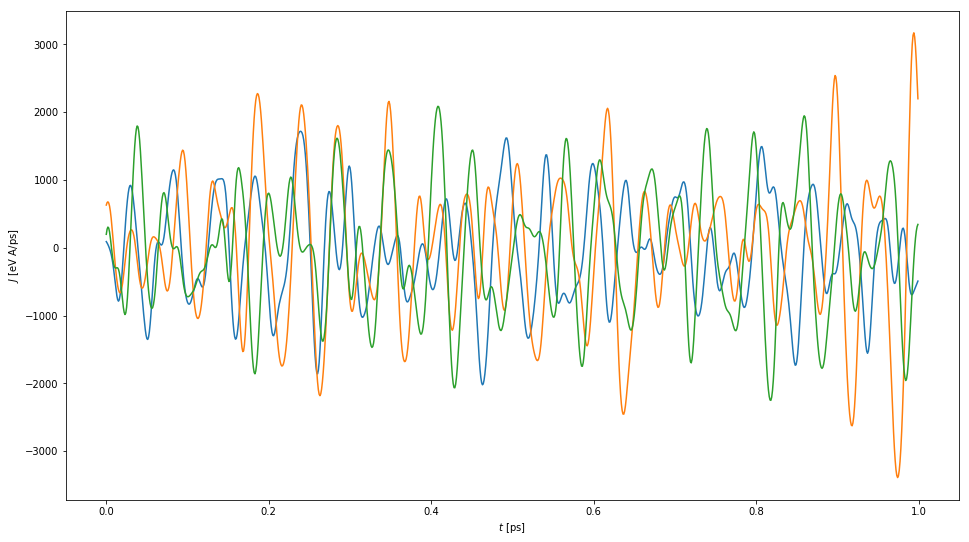

In [ ]:
# trajectory
plt.plot(np.arange(1000)*j.DT_FS/1000., j.traj[:1000,:]);
plt.xlabel(r'$t$ [ps]')
plt.ylabel(r'$J$ [eV A/ps]');

Compute the **Power Spectral Density** and filter it for visualization.

In [ ]:
# Periodogram with give filtering window width
j.plot_periodogram(PSD_FILTER_W=0.5)
#plt.xlim([0, 100]);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f67e8a40ed0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f67e8d5af50>], dtype=object)

## 3. Resampling
Choose the resampling frequency $f^*$ or the resampling step (TSKIP). Visualize the resulting PSD.
(Notice: if you choose an $f^*$ it may be approximated to the closest applicable).

In [ ]:
FSTAR_THZ = 28.0
jf, ax = tc.heatcurrent.resample_current(j, fstar_THz=FSTAR_THZ, plot=True, freq_units='thz')
plt.xlim([0, 80])
ax[1].set_ylim([12,18]);
ax[1].set_xlim()

In [ ]:
ax = jf.plot_periodogram(PSD_FILTER_W=0.1)
ax[1].set_ylim([12,18]);

## 4. Cepstral Analysis
- compute 
Perform Cepstral Analysis:
 - first the theoretical distribution parameters are computed
 - then the Cepstral coefficients are computed
 - estimates of $\kappa$ are performed

In [ ]:
jf.cepstral_analysis(aic_type='aic', Kmin_corrfactor=1.0)

In [ ]:
# Cepstral Coefficients
print jf.dct.logpsdK

plt.plot(jf.dct.logpsdK, 'o-', c=c[0])
plt.plot(jf.dct.logpsdK + jf.dct.logpsdK_THEORY_std, '--', c=c[0])
plt.plot(jf.dct.logpsdK - jf.dct.logpsdK_THEORY_std, '--', c=c[0])
plt.xlim([0, 50])
plt.ylim([-0.5, 0.5]);
plt.grid();

In [ ]:
# AIC
plt.plot(jf.dct.aic, '.-', c=c[0])
plt.xlim([0,200])
plt.ylim([2800, 3000]);

print 'K of AIC_min = {:d}'.format(jf.dct.aic_Kmin)
print 'AIC_min = {:f}'.format(jf.dct.aic_min)

Plot $L_0$ (tau) as a function of the cutoff

In [ ]:
# L_0 as a function of cutoff K
plt.plot(jf.dct.logtau, '.-', c=c[0])
plt.plot(jf.dct.logtau + jf.dct.logtau_THEORY_std, '--', c=c[0])
plt.plot(jf.dct.logtau - jf.dct.logtau_THEORY_std, '--', c=c[0])
plt.xlim([0,200])
plt.ylim([12.5, 14.5]);
plt.axvline(x=jf.dct.aic_Kmin, ls='--', c='r')

print 'K of AIC_min = {:d}'.format(jf.dct.aic_Kmin)
print 'AIC_min = {:f}'.format(jf.dct.aic_min)

Print the results :)

In [ ]:
# Manually print results
print '  L_0* = {:15g} +/- {:10f}'.format(jf.dct.logtau_Kmin, jf.dct.logtau_std_Kmin)
print '  S_0* = {:15f} +/- {:10f}'.format(jf.dct.tau_Kmin, jf.dct.tau_std_Kmin)
print '-------------------------------------------------'
print '  kappa* = {:15f} +/- {:10f}  W/mK'.format(jf.kappa_Kmin, jf.kappa_Kmin_std)
print '-------------------------------------------------'

You can also visualize the filtered PSD...

In [ ]:
# filtered log-PSD
ax = j.plot_periodogram(0.5)
ax = jf.plot_periodogram(0.5, axes=ax)
ax[0].plot(jf.freqs_THz, jf.dct.psd,    c=c[2], lw=2, label='filtered')
ax[1].plot(jf.freqs_THz, jf.dct.logpsd, c=c[2], lw=2, label='filtered')
ax[0].axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
ax[1].axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
plt.xlim([0., 50.])
ax[1].set_ylim([12,18])
ax[0].legend(['original', 'resampled', 'cepstrum-filtered'])
ax[1].legend(['original', 'resampled', 'cepstrum-filtered']);